<a href="https://colab.research.google.com/github/richardmukechiwa/Sentiment-Analysis-with-BERT/blob/main/SentimentAnalysisBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import torch
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import requests
import re


# **Instantiate the Model**

In [31]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model =AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

## **Encode and Calculate Sentiment**

In [32]:
#extract tokens of a sentence
tokens = tokenizer.encode("What a worst of resources", return_tensors='pt')
tokens[0]

tensor([  101, 11523,   143, 43060, 10108, 19030,   102])

In [33]:
#retrieve the tokenized sentence
tokenizer.decode(tokens[0])

'[CLS] what a worst of resources [SEP]'

In [34]:
# test the tokens in the model
result = model(tokens)
result

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.2731,  1.9730, -0.3172, -2.6130, -2.6067]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [35]:
# extract useful sentiments using pytorch's argmax
torch.argmax(result.logits)


tensor(0)

In [36]:
# convert the tensor to an integer
int(torch.argmax(result.logits))+1 # The higher the number the better the sentiment

1

# **Collect Reviews**

In [37]:
# Extracting reviews from Yelp website to do Sentiment Analysis
r = requests.get("https://www.sitejabber.com/reviews/hawalili.com")
soup = BeautifulSoup(r.text, "html.parser")
regex = re.compile(".*margin-bottom:10px*.")
results = soup.find_all('p',{'style': regex})
reviews = [result.text for result in results]

In [38]:
#show results
#r.text

In [39]:
# first result from the soup
results[0].text

'Always good to find good shop. And this one is exactly one! Good looking shirts and other things! Thank you will buy again'

In [40]:
# the reviews collected
reviews[1:3]

["I've found the BEST place to shop for my wardrobe! I have 13 of these super light, super graphics shiirts in my closet. Yesterday, I ordered 15 more after an exhaustive review of the web site. Now, it'll be 28! In my building, I'm now well known for my shirt wardrobe. Some are beautiful, some exotic, some funny, ALL fun. The best part is the price. $6.00 up to perhaps $25, but mostly economical. Dressing up can be fun, too!",
 "If it sounds too good to be true it usually is. The shirts they show on their website look great but what will show up at your front door is completely different, I would be embarrassed to wear these shirts in public, and the sizes are completely off. If you have a problem you have to pay all kinds of fees and spend time trying to return it. This is not an Amazon like company. Don't waste your money buying anything from this company,"]

# **Load Reviews into DataFrame and Score**

In [41]:
# using pandas, create a dataframe
df = pd.DataFrame(reviews, columns = ['Reviews'])
df.head()

,Reviews
0,Always good to find good shop. And this one is...
1,I've found the BEST place to shop for my wardr...
2,If it sounds too good to be true it usually is...
3,"I purchased 5 shirts from this site, the quali..."
4,"There were 2 shirts with a similar print, one ..."


In [42]:
3 # creating a sentiments score function
def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))+1

In [43]:

# testing the function with the reviews
sentiment_score(df["Reviews"].iloc[1])

4

In [44]:
# Applying the function on all the reviewxs in the dataframe using .apply and lambda
df['Sentiments'] = df['Reviews'].apply(lambda x: sentiment_score(x))
df.head()

,Reviews,Sentiments
0,Always good to find good shop. And this one is...,5
1,I've found the BEST place to shop for my wardr...,4
2,If it sounds too good to be true it usually is...,1
3,"I purchased 5 shirts from this site, the quali...",1
4,"There were 2 shirts with a similar print, one ...",1


In [53]:
#separating positive and negative sentiments
df_positive = df[df['Sentiments']>= 3]
df_negative = df[ df['Sentiments']<3 ]

print('Positve Sentiments')
print(df_positive.head())
print()
print()
print("Negative Sentiments")
print(df_negative.head())

Positve Sentiments
                                             Reviews  Sentiments
0  Always good to find good shop. And this one is...           5
1  I've found the BEST place to shop for my wardr...           4
5  Effective and relevant to meet an immediate ne...           5
7  Site has cool shirts and is legit but expect 3...           3
8  Great shopping experience, really easy to use....           4


Negative Sentiments
                                              Reviews  Sentiments
2   If it sounds too good to be true it usually is...           1
3   I purchased 5 shirts from this site, the quali...           1
4   There were 2 shirts with a similar print, one ...           1
6   Coupon code new12 not accepted even though I a...           2
10  Offer discount for new customers, but renege a...           2


# **Creating a WordCloud for sentiments**

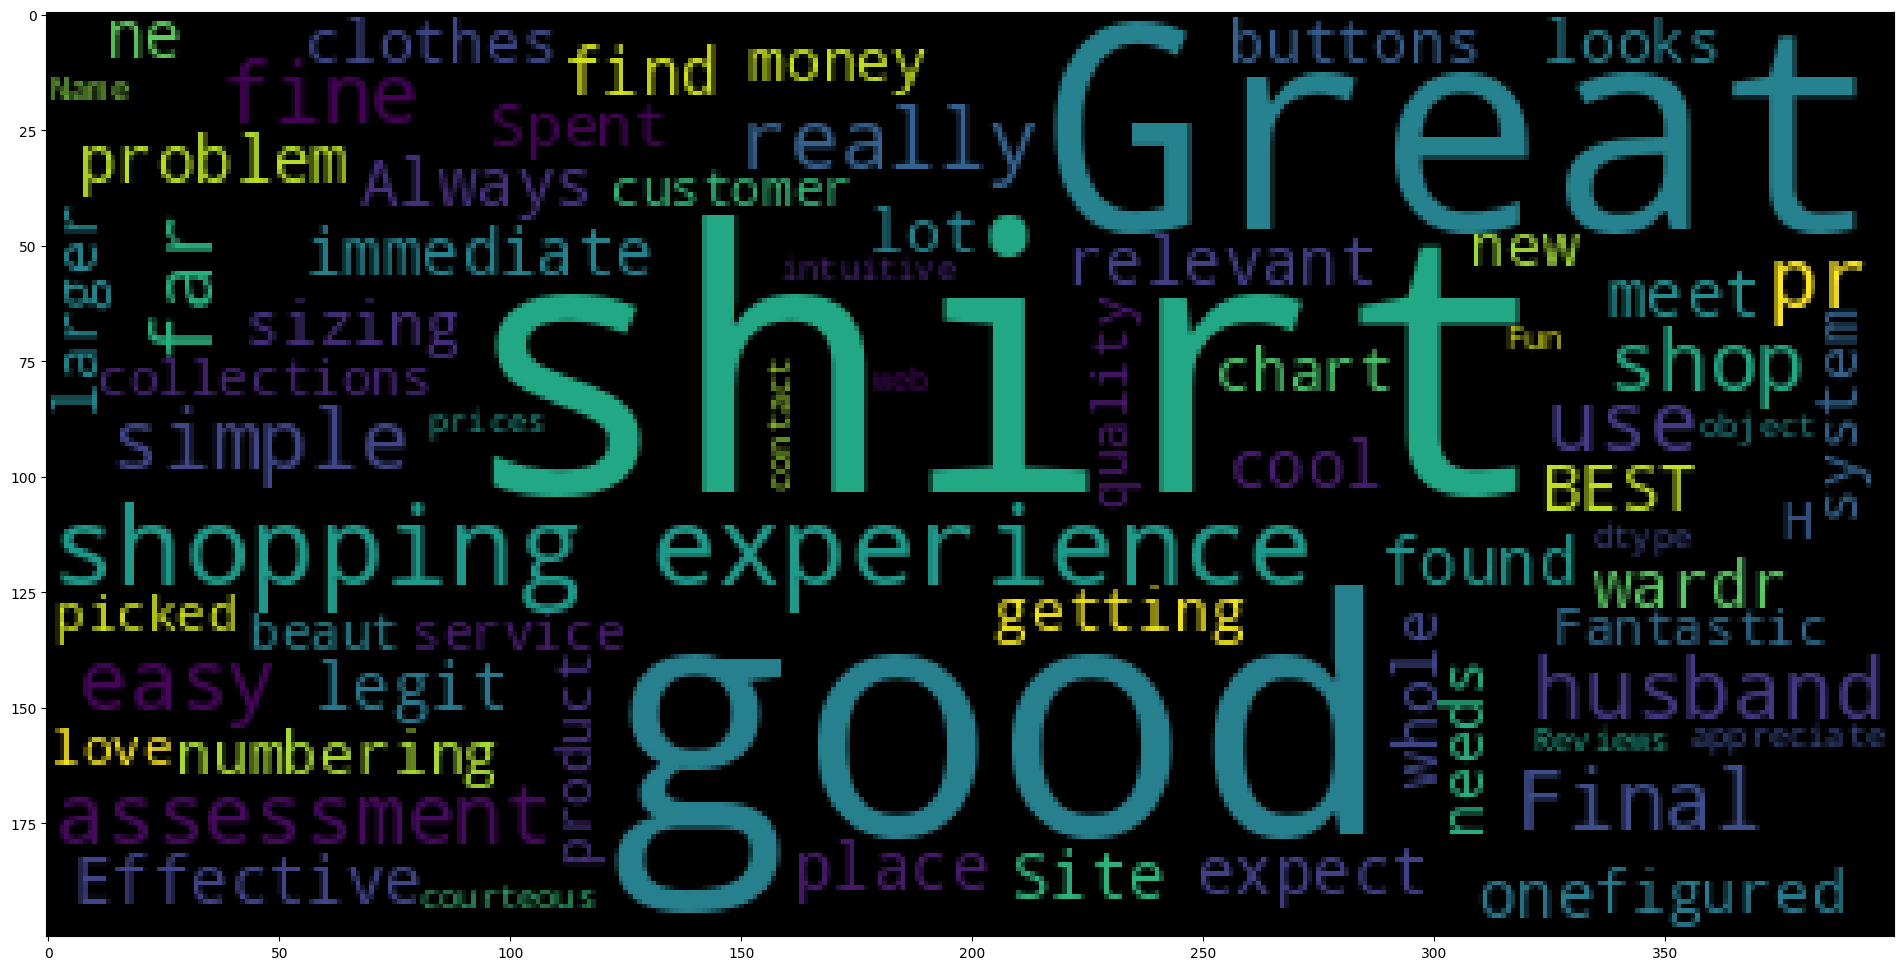

In [56]:
#importing wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# word cloud for positive sentiments

positive_cloud = WordCloud(max_words = 200).generate(str(df_positive['Reviews']))
plt.figure(figsize = (24, 12))
plt.imshow(positive_cloud)
plt.show()

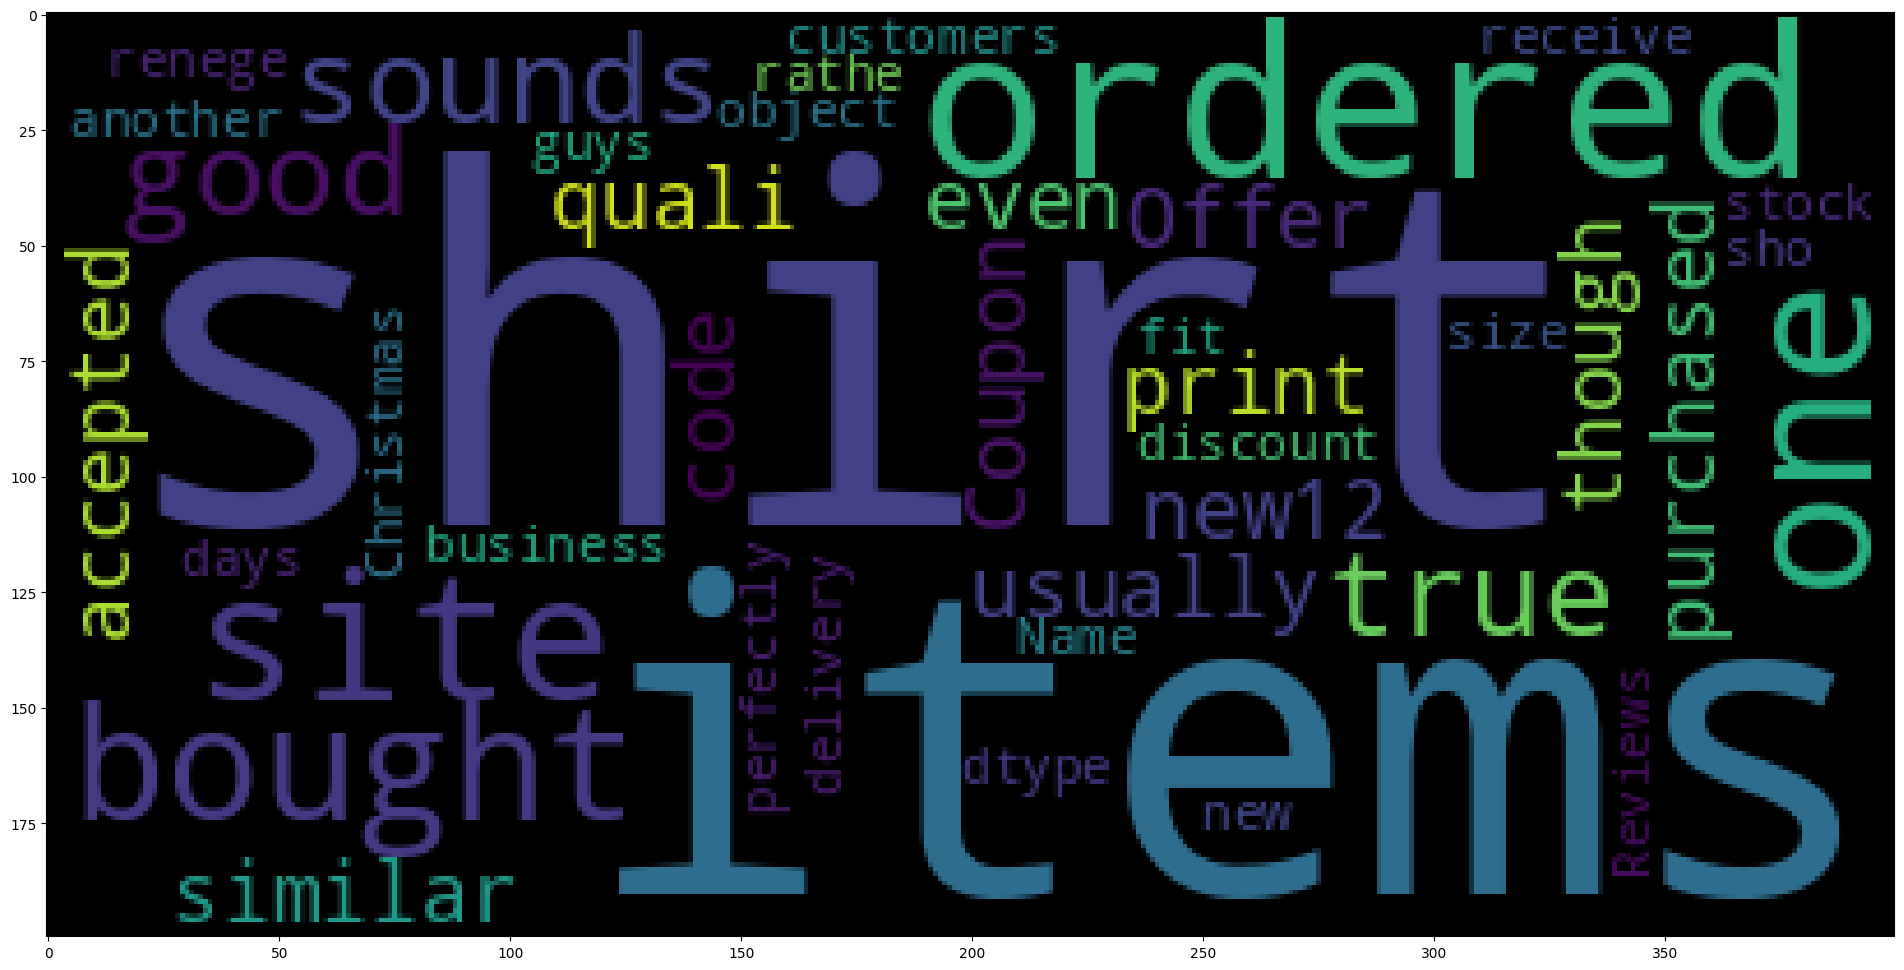

In [59]:
# word cloud for negative sentiments
negative_cloud = WordCloud(max_words=200).generate(str(df_negative["Reviews"]))
plt.figure(figsize=(24, 12))
plt.imshow(negative_cloud)
plt.show()